# Calculate surface convergence of freshwater

In this notebook we calculate the freshwater convergence based on the surface salinity and velocity - the associated figures are produced in `AMOC_deep_mixing_regions.ipynb`

## Imports

In [1]:
print('go')
import optim_esm_tools as oet
%run ../amoc_collapse_scripts/imports.py
from amoc_collapse_scripts import amoc_deep_dive, helper_scripts, multiprocess, manual_msft, path_setup

go


## Pre-processing
We start with the raw historical + ssp files of the models of interest, followed by the operations:
 1. Yearly averaging 
 2. Regridding to a bilinear n90 grid
 3. Combining historical and ssp files to a single file for each ssp for each model

In [2]:
make_yearly = (
    sorted(glob.glob(f'{path_setup.FRESHWATER_TRANSPORT_BASE}/[sv]o_*CanESM5*.nc'))
    + sorted(glob.glob(f'{path_setup.FRESHWATER_TRANSPORT_BASE}/[sv]o_*IPSL-CM6*.nc'))
    + sorted(glob.glob(f'{path_setup.FRESHWATER_TRANSPORT_BASE}/[sv]o_*ACCESS*.nc'))
)

yearly averaging

In [3]:
cmds = []
for f in make_yearly:
    if os.path.exists(f"{f}_yearly"):
        continue
    cmds.append(f"cdo -v yearmonmean {f} {f}_yearly")
if cmds:
    r = multiprocess.submit_jobs(cmds, n_max=40)
    print(r)

regridding

In [4]:
cmds = []
for f in oet.utils.tqdm(sorted(make_yearly)):
    if os.path.exists(f"{f}_yearly_n90"):
        continue
    assert os.path.exists(f"{f}_yearly"), f"{f}_yearly"
    oet.analyze.pre_process._remove_bad_vars(f"{f}_yearly")
    cmds.append(f"cdo -v remapbil,n90 {f}_yearly {f}_yearly_n90")
if cmds:
    r = multiprocess.submit_jobs(cmds, n_max=40)
    print(r)

  0%|          | 0/280 [00:00<?, ?it/s]

merging

In [5]:
jobs = [
    "cdo -v mergetime {base}/vo_Omon_{model}_historical_*.nc_yearly_n90 {base}/vo_Omon_{model}_ssp585_*.nc_yearly_n90 {base}/vo_Omon_{model}_hist_ssp585_time_merged_yearly_n90.nc",
    "cdo -v mergetime {base}/so_Omon_{model}_historical_*.nc_yearly_n90 {base}/so_Omon_{model}_ssp585_*.nc_yearly_n90 {base}/so_Omon_{model}_hist_ssp585_time_merged_yearly_n90.nc",
]

In [6]:
models = 'ACCESS-ESM1-5 ACCESS-CM2 IPSL-CM6A-LR CanESM5'.split()

In [7]:
for p in glob.glob(f'{path_setup.FRESHWATER_TRANSPORT_BASE}/so_Omon_IPSL-CM6A-LR_*.nc_yearly_n90'):
    oet.analyze.pre_process._remove_bad_vars(p)

In [8]:
sub_jobs = [
    j.replace("\n", " ").format(model=m, base=path_setup.FRESHWATER_TRANSPORT_BASE)
    for j in jobs
    for m in models
]
sub_jobs = [j for j in sub_jobs if not os.path.exists(j.split(" ")[-1])]
if sub_jobs:
    r = multiprocess.submit_jobs(sub_jobs)
    print(r)

## Surface freshwater calculation

In [9]:
cell_area = oet.load_glob(f"{path_setup.FRESHWATER_TRANSPORT_BASE}/area.nc")

In [10]:
def pre_process_vo_and_so(ds_so, ds_vo):
    amoc_deep_dive.set_time_int(ds_so)
    amoc_deep_dive.set_time_int(ds_vo)

    lev_dim = manual_msft.get_lev_coord(ds_so)

    if lev_dim != "lev":
        ds_so = ds_so.rename(**{lev_dim: "lev"})
        ds_vo = ds_vo.rename(**{lev_dim: "lev"})
        ds_so = ds_so.rename(**{lev_dim + "_bnds": "lev_bnds"})
        ds_vo = ds_vo.rename(**{lev_dim + "_bnds": "lev_bnds"})

    # NB! we only take the upper layer of the data
    ds_vo = ds_vo.isel(lev=slice(0, 1)).load()
    ds_so = ds_so.isel(lev=slice(0, 1)).load()

    ds_vo["cell_area"] = cell_area["cell_area"].copy()
    ds_so["cell_area"] = cell_area["cell_area"].copy()

    ds_so["lev_size"] = xr.DataArray(np.diff(ds_so["lev_bnds"])[:, 0], dims="lev")
    ds_vo["lev_size"] = xr.DataArray(np.diff(ds_vo["lev_bnds"])[:, 0], dims="lev")

    lat_v = ds_vo["lat"].values
    lon_v = ds_vo["lon"].values

    dx_ar = np.zeros((len(lat_v), len(lon_v)), dtype=np.float32)
    for lat_i, lat in enumerate(lat_v):
        dx = oet.analyze.clustering._distance(
            [lat, lon_v[0], lat, lon_v[1]], force_math=True
        )
        dx_ar[lat_i, :] = dx

    ds_so["dx"] = xr.DataArray(dx_ar, dims="lat lon".split())
    ds_vo["dx"] = xr.DataArray(dx_ar, dims="lat lon".split())

    ds_so_m = ds_so.where(mask, drop=True).load()
    ds_so_m["lev_size"] = ds_so_m["lev_size"].mean("lon lat".split())
    ds_vo_m = ds_vo.where(mask, drop=True).load()
    ds_vo_m["lev_size"] = ds_vo_m["lev_size"].mean("lon lat".split())
    return ds_so_m, ds_vo_m

In [11]:
@staticmethod
def approximate_atlantic(
    mask: xr.DataArray, lon_min: float = -70.0, lon_max: float = 20.0
) -> xr.DataArray:
    new_mask = mask.copy()

    new_mask[:, ((new_mask.lon > 30) & (new_mask.lon < 360 + lon_min))] = False

    # 2d indexing on xr.DataArray doesn't work, so use numpy
    _new_mask_array = new_mask.values

    # everything outside 70W:20E
    _new_mask_array[
        (new_mask.lat <= 0)
        & (new_mask.lon < (360 + lon_min))
        & (new_mask.lon > lon_max)
    ] = False
    _new_mask_array[
        (new_mask.lat >= 0)
        & (new_mask.lon < (360 + lon_min))
        & (new_mask.lon > lon_max)
    ] = False

    # Remove mediteranian France/Italy
    _new_mask_array[
        (new_mask.lat > 10)
        & (new_mask.lat < 50)
        & (new_mask.lon < 360 + lon_min)
        & (new_mask.lon >= 0)
    ] = False

    # Remove Straight of Gibraltar
    _new_mask_array[
        (new_mask.lat > 10) & (new_mask.lat < 40) & (new_mask.lon >= 355)
    ] = False
    new_mask.data = _new_mask_array

    return new_mask


amoc_deep_dive.PlotProducer.approximate_atlantic = approximate_atlantic

In [12]:
def get_mask_atlantic():
    mask = amoc_deep_dive._base_mask(lat_max=90, lat_min=-90, lon_min=-100).copy()
    a = (mask.lat < 10) & (mask.lon < 290) & (mask.lon > 70)
    a = a | (mask.lat < 20) & (mask.lon < 275) & (mask.lon > 70)

    # mask west of greenland
    a = a | (mask.lat > 50) & (mask.lon < 305) & (mask.lon > 70) & (mask.lat < 80)
    a = a | (mask.lat > 60) & (mask.lon < 315) & (mask.lon > 70) & (mask.lat < 80)
    a = a | (
        regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50.mask(mask) == 17
    )

    # a= a | (mask.lat<-60) & (mask.lon<290) & (mask.lon>70)
    mask.data[a.values] = False
    return mask

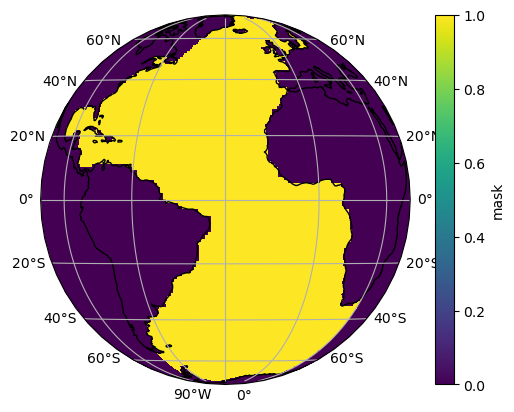

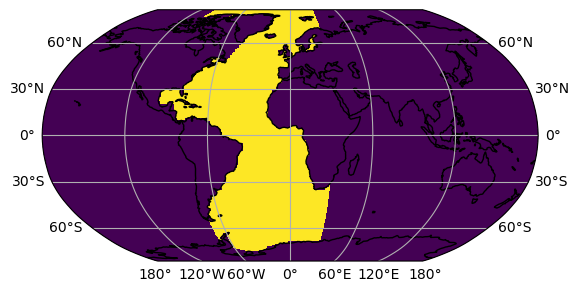

In [13]:
mask = get_mask_atlantic()
oet.plotting.plot.plot_da(
    mask,
    projection="NearsidePerspective",
    setup_kw=dict(central_longitude=-30, central_latitude=0, satellite_height=40e7),
)

plt.show()
oet.plotting.plot.plot_da(
    mask,
    add_colorbar=False,
)

In [14]:
@numba.njit
def _norm_and_int(nlat, nlon, nlev, _sum, _norm, v, dz_array, dx_array, _weight):
    for lat_i in range(nlat):
        for lon_i in range(nlon):
            dx = dx_array[lat_i][lon_i]
            for lev_i in range(nlev):
                v_sel = float(v[lev_i][lat_i][lon_i])
                if np.isnan(v_sel):
                    break
                dz = dz_array[lev_i]

                dxdz = dx * dz

                _sum[lat_i] += v_sel * dxdz / _weight
                _norm[lat_i] += dxdz / _weight

In [15]:
def _int_dx_dz_v_dot_s(ds_s, ds_v, dx_field="dx", dz_field="lev_size", **kw):
    v = ds_s[ds_s.variable_id].values * ds_v[ds_v.variable_id].values
    dz_array = ds_s[dz_field].values
    dx_array = ds_s[dx_field].values
    lat_v = ds_s["lat"].values
    lon_v = ds_s["lon"].values

    assert np.array_equal(dz_array, ds_v[dz_field].values)
    assert np.array_equal(
        dx_array[~np.isnan(dx_array)], ds_v[dx_field].values[~np.isnan(dx_array)]
    )
    assert np.array_equal(lat_v, ds_v["lat"].values)
    assert np.array_equal(lon_v, ds_v["lon"].values)
    nlev, nlat, nlon = v.shape
    _weight = 1
    _sum = np.zeros(nlat, np.float64)
    _norm = np.zeros(nlat, np.float64)
    _norm_and_int(nlat, nlon, nlev, _sum, _norm, v, dz_array, dx_array, _weight)
    return _sum, _norm


def int_dx_dz_v_dot_s(*a, **kw):
    s, _ = _int_dx_dz_v_dot_s(*a, **kw)
    return s


def calc_m_tot(
    *a,
    s0=35.0,
    **kw,
):
    res = (-1 / s0) * int_dx_dz_v_dot_s(*a, **kw)
    km_to_meter = 1e3
    m_cubed_per_s_to_sv = 1e6
    return res * km_to_meter / m_cubed_per_s_to_sv

In [16]:
def write_mtot_mask(
    ds_so,
    ds_vo,
    save_as=f"{path_setup.FRESHWATER_TRANSPORT_BASE}/mtot_MRI-ESM2-0_ssp585.nc",
):
    ds_so_m, ds_vo_m = pre_process_vo_and_so(ds_so, ds_vo)

    temp = ds_so_m.copy()
    del temp["lev"]
    s0 = helper_scripts.weighted_mean_array(temp.squeeze(), field="so").mean()

    M_tot = [
        calc_m_tot(ds_so_m.isel(time=i), ds_vo_m.isel(time=i), s0=s0)
        for i, _ in oet.utils.tqdm(list(enumerate(ds_so_m["time"])))
    ]

    M_tot = xr.DataArray(np.array(M_tot), dims=("time", "lat"))
    M_tot["time"] = ds_so_m["time"]
    M_tot["lat"] = ds_so_m["lat"]

    M_tot = M_tot.T
    M_tot.attrs["label"] = (
        "$M_\\mathrm{surface}$ [Sv]\n$M_\\mathrm{surface}(t,y)=\\frac{-1}{S_0}\\int_{-1\,\\mathrm{m}}^{0\,\\mathrm{m}}\\int v(t,x,y,z)\\cdot S(t,x,y,z)\\mathrm{d}x\mathrm{d}z$"
    )
    ds_mot = xr.Dataset(dict(mtot=M_tot))
    if os.path.exists(save_as):
        os.remove(save_as)
    ds_mot.to_netcdf(save_as)
    return ds_mot

In [17]:
paths = lambda model: [
    f"{path_setup.FRESHWATER_TRANSPORT_BASE}/so_Omon_{model}_hist_ssp585_time_merged_yearly_n90.nc",
    f"{path_setup.FRESHWATER_TRANSPORT_BASE}/vo_Omon_{model}_hist_ssp585_time_merged_yearly_n90.nc",
    f"{path_setup.FRESHWATER_TRANSPORT_BASE}/mtot_{model}_ssp585.nc",
]

  0%|          | 0/4 [00:00<?, ?it/s]

Ran into /data/volume_2/manual_download/so_Omon_ACCESS-ESM1-5_hist_ssp585_time_merged_yearly_n90.nc has len 335
Ran into /data/volume_2/manual_download/so_Omon_ACCESS-CM2_hist_ssp585_time_merged_yearly_n90.nc has len 295


  0%|          | 0/451 [00:00<?, ?it/s]

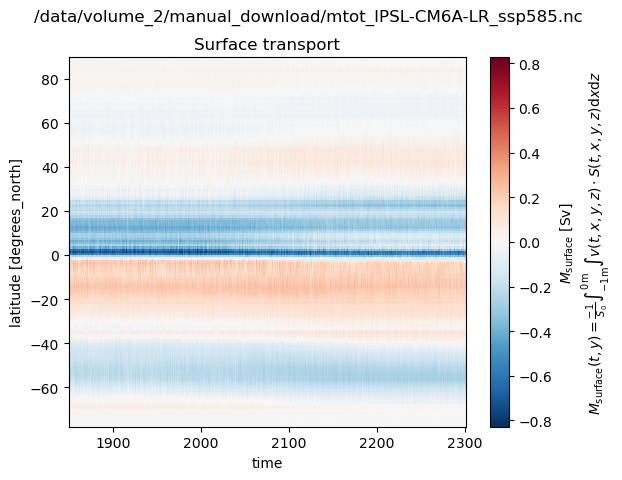

  0%|          | 0/451 [00:00<?, ?it/s]

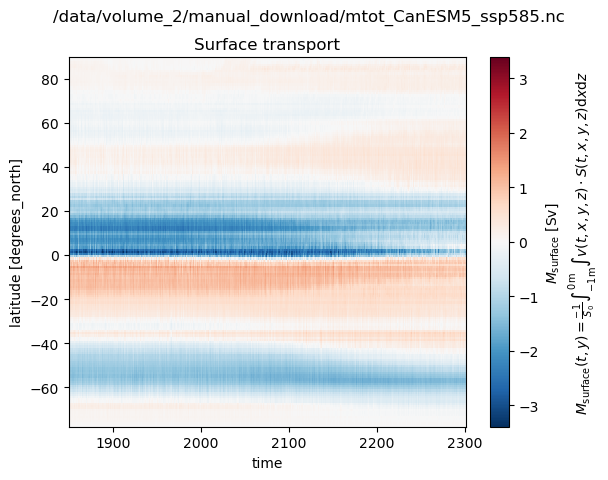

In [18]:
for p_so, p_vo, p_mtot in oet.utils.tqdm([paths(m) for m in models]):
    try:
        ds_so = oet.load_glob(p_so)
        ds_vo = oet.load_glob(p_vo)
        if len(ds_so["time"]) not in [450, 451]:
            raise ValueError(f"{p_so} has len {len(ds_so.time)}")

        if len(ds_vo["time"]) not in [450, 451]:
            raise ValueError(f"{p_vo} has len {len(ds_vo.time)}")

        ds_mtot = write_mtot_mask(ds_so, ds_vo, p_mtot)
        ds_mtot["mtot"].plot(
            cbar_kwargs=dict(
                label="$M_\\mathrm{surface}$ [Sv]\n$M_\\mathrm{surface}(t,y)=\\frac{-1}{S_0}\\int_{-1\,\\mathrm{m}}^{0\,\\mathrm{m}}\\int v(t,x,y,z)\\cdot S(t,x,y,z)\\mathrm{d}x\mathrm{d}z$ "
            )
        )
        plt.title("Surface transport")
        plt.suptitle(p_mtot)
        plt.show()
    except Exception as e:
        print(f'Ran into {e}')